In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Importons aussi notre fonction de recherche de description dans les metadatas :
from description import search_desc

# Import des données

In [2]:
data_2015 = pd.read_csv('2015-building-energy-benchmarking.csv')
data_2016 = pd.read_csv('2016-building-energy-benchmarking.csv')

# Nettoyage

## Traitement des colonnes différentes pour 2015 et 2016

In [3]:
data_2015.columns[~data_2015.columns.isin(data_2016.columns)]

Index(['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'Zip Codes'],
      dtype='object')

In [4]:
data_2016.columns[~data_2016.columns.isin(data_2015.columns)]

Index(['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude',
       'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

In [5]:
# Tout d'abord les colonnes n'ayant pas le même nom mais représentant la même chose : 
data_2015 = data_2015.rename(columns = {'Zip Codes':'ZipCode', 
                                        'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity',
                                       'GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions',
                                       })

#Puis la colonne Location en 2015 qui contient en fait la latitude/longitude ; 
data_2015['lat_lon'] = data_2015['Location'].str.rsplit(',').str[0:2]
data_2015['Latitude'] = data_2015['lat_lon'].str[0].str.split(':').str[1]
data_2015['Latitude'] = data_2015['Latitude'].str.split("'").str[1].astype(float).round(3)
data_2015['Longitude'] = data_2015['lat_lon'].str[1].str.split(':').str[1]
data_2015['Longitude'] = data_2015['Longitude'].str.split("'").str[1].astype(float).round(3)

#Puis la colonne addresse : 
data_2015['Address'] = data_2015['Location'].str.rsplit(',').str[2]
data_2015['Address'] = data_2015['Address'].str.rsplit(':').str[2]

#Enfin, on delete les colonnes inutiles
data_2015 = data_2015.drop(columns=['lat_lon', 'Location'])

## Concat pour avoir un seul jeu de données

In [6]:
data = pd.concat([data_2016, data_2015], sort=True, join='inner')

In [7]:
data.head()

,Address,BuildingType,ComplianceStatus,CouncilDistrictCode,DataYear,DefaultData,ENERGYSTARScore,Electricity(kBtu),Electricity(kWh),GHGEmissionsIntensity,...,SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),TaxParcelIdentificationNumber,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,TotalGHGEmissions,YearBuilt,YearsENERGYSTARCertified,ZipCode
0,405 Olive way,NonResidential,Compliant,7,2016,False,60.0,3946027.0,1.156514e+06,2.83,...,182.500000,189.000000,2003882.00,0659000030,NaN,NaN,249.98,1927,NaN,98101.0
1,724 Pine street,NonResidential,Compliant,7,2016,False,61.0,3242851.0,9.504252e+05,2.86,...,176.100006,179.399994,0.00,0659000220,Restaurant,4622.0,295.86,1996,NaN,98101.0
2,1900 5th Avenue,NonResidential,Compliant,7,2016,False,43.0,49526664.0,1.451544e+07,2.19,...,241.899994,244.100006,21566554.00,0659000475,NaN,NaN,2089.28,1969,NaN,98101.0
3,620 STEWART ST,NonResidential,Compliant,7,2016,False,56.0,2768924.0,8.115253e+05,4.67,...,216.199997,224.000000,2214446.25,0659000640,NaN,NaN,286.43,1926,NaN,98101.0
4,401 LENORA ST,NonResidential,Compliant,7,2016,False,75.0,5368607.0,1.573449e+06,2.88,...,211.399994,215.600006,0.00,0659000970,Swimming Pool,0.0,505.01,1980,NaN,98121.0


In [8]:
data.shape

(6716, 43)

On reset les index (venant de deux fichiers différents cela va poser problème par la suite sinon)

In [9]:
data = data.reset_index().drop(columns=['index'])

## Gestion des doublons

Sur les lignes : 

In [10]:
doublon = data.groupby(['Address'])['DefaultData'].count()
doublon = doublon.reset_index()
doublon = doublon[doublon['DefaultData'] > 1]
doublon.shape

(54, 2)

54 buildings sont donc comptés plusieurs fois dans le jeu de données, supprimons les duplicates

In [11]:
data = data.drop_duplicates(subset = 'Address')

## Variables cibles (à changer de categories après)

In [12]:
search_desc("SiteEnergyUseWN(kBtu)", 2016)

'The annual amount of energy consumed by the property from all sources of energy, adjusted to what the property would have consumed during 30-year average weather conditions.'

In [13]:
search_desc("TotalGHGEmissions", 2016)

"The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu. "

On a désormais nos deux variables cible : SiteEnergyUseWN(kBtu) et TotalGHGEmissions

In [14]:
# Col useless : 
# SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, OSEBuildingID, ListOfAllPropertyUseTypes,
# LargestPropertyUseTypeGFA, LargestPropertyUseType, Electricity(kBtu), 

In [15]:
#Variable cible 1 : 
#data_2016["Electricity(kWh)"] ?? Ou bien data_2016["SiteEnergyUseWN(kBtu)"], NaturalGas(kBtu) ? all ?

#Variable cible 2 : 
#data_2016["TotalGHGEmissions"] ??

## Gestion des valeurs manquantes

### Plus de 50% des valeurs manquantes 

In [16]:
# On utilise une boucle pour récupérer le taux de valeurs manquantes
taille = len(data)
nulle = []
for i in data.columns:
    nbr = len(data[i])-len(data[i].dropna())
    taux = nbr/taille*100
    col = data[i]
    if taux >= 50:
        del data[i] #On enlève ensuite les colonnes possédant + de 50% de valeurs manquantes

data.shape

(6633, 37)

6 colonnes ont été retirées

### Moins de 50% de valeurs manquantes

A voir mais il semnle qu'on ne puisse pas gérer les valeurs manquantes quand il y en a moins de 50% 

## Apperçu des données

In [17]:
data.describe()

,CouncilDistrictCode,DataYear,ENERGYSTARScore,Electricity(kBtu),Electricity(kWh),GHGEmissionsIntensity,LargestPropertyUseTypeGFA,Latitude,Longitude,NaturalGas(kBtu),...,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),TotalGHGEmissions,YearBuilt,ZipCode
count,6633.000000,6633.000000,5040.000000,6.614000e+03,6.614000e+03,6614.000000,6.480000e+03,6633.000000,6633.000000,6.614000e+03,...,6616.000000,6617.000000,6.618000e+03,6.617000e+03,6614.000000,6614.000000,6.614000e+03,6614.000000,6633.000000,6618.000000
mean,4.451379,2015.505654,68.057738,3.569893e+06,1.046255e+06,1.072903,7.708754e+04,47.624300,-122.334910,1.296146e+06,...,53.653779,56.752138,5.157895e+06,5.198195e+06,132.112262,136.939885,2.628534e+05,114.014072,1968.038293,58811.118465
std,2.119207,0.500006,26.954432,1.249266e+07,3.661347e+06,1.731518,1.688085e+05,0.047691,0.027222,5.640409e+06,...,54.152604,55.439443,1.813005e+07,1.493918e+07,131.968442,131.577147,3.724592e+06,478.407081,33.069476,39668.951631
min,1.000000,2015.000000,1.000000,-1.154170e+05,-3.382680e+04,-0.020000,5.656000e+03,47.499000,-122.414250,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000e+00,-2.000000,-2.100000,0.000000e+00,-0.800000,1900.000000,17916.000000
25%,3.000000,2015.000000,52.000000,6.353415e+05,1.862080e+05,0.160000,2.500000e+04,47.600000,-122.350660,0.000000e+00,...,27.500000,29.500000,9.154818e+05,9.771500e+05,73.900002,79.099998,0.000000e+00,9.290000,1948.000000,18390.000000
50%,4.000000,2016.000000,76.000000,1.161062e+06,3.402740e+05,0.530000,3.950700e+04,47.618720,-122.332790,3.015140e+05,...,37.799999,40.700000,1.775922e+06,1.913488e+06,95.199998,101.700000,0.000000e+00,32.905000,1974.000000,98101.000000
75%,7.000000,2016.000000,90.000000,2.763077e+06,8.098033e+05,1.270000,7.478375e+04,47.657130,-122.319740,1.143296e+06,...,59.500000,64.200000,4.108349e+06,4.345708e+06,142.300000,148.175002,0.000000e+00,91.000000,1996.000000,98115.000000
max,7.000000,2016.000000,100.000000,6.570744e+08,1.925775e+08,34.090000,9.320156e+06,47.734000,-122.220000,2.979090e+08,...,834.400024,834.400024,8.739237e+08,4.716139e+08,2620.000000,2620.000000,1.349435e+08,16870.980000,2015.000000,98272.000000


## Division du dataset en deux parties

Divisons le dataset en deux parties, une partie quanti et une quali, cette division est effectuées sur les variables qualitatives et celles quantitatives

### Ajout du type de variable sur le df

Import des données et concat 

In [18]:
type_2015 = pd.read_csv('csv_metadata/metadata2015.csv')
type_2016 = pd.read_csv('csv_metadata/metadata2016.csv')
type_all = pd.concat([type_2015, type_2016], join='inner').drop_duplicates()[['name', 'datatype']]

In [19]:
#Deux variables ont un mauvais datatype, changeons cela : 
type_all = type_all.set_index('name')
type_all.loc['TotalGHGEmissions', 'datatype'] = 'number'
type_all.loc['GHGEmissionsIntensity', 'datatype'] = 'number'
type_all = type_all.reset_index()

Création d'une liste ayant le nom de la colonne et le type de données

In [20]:
quanti = type_all[type_all['datatype'] == 'number']['name']
quali = type_all[(type_all['datatype'] == 'text') | (type_all['datatype'] == 'location')]['name']

In [21]:
#On crée ensuite une variable contenant les colonnes quanti et une les colonnes quali :
col_quanti = data.columns[data.columns.isin(quanti)]
col_quali = data.columns[data.columns.isin(quali)]

#Puis on filtre les données sur ces colonnes :
data_quanti = data[col_quanti]
data_quali = data[col_quali]

In [22]:
data_quanti.shape

(6633, 27)

## Traitement des valeurs abberantes

### Valeurs minimales

In [23]:
for i in data_quanti.columns:
    if i == 'Longitude':
        data_quanti.loc[:,i] = data_quanti.loc[:,i]
    elif i == 'Latitude':
        data_quanti.loc[:,i] = data_quanti.loc[:,i]
    else:
        data_quanti.loc[~ (data_quanti.loc[:,i] > 0), i] = np.nan

C:\Users\jpaul\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\jpaul\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\jpaul\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### Valeurs Maximales

Il est pour l'instant très compliqué de gérer les valeurs maximales abberantes ; Il va nous falloir plus d'analyses afin de pouvoir connaitre les outliers. <br/>
Une idée est quand même présente : Prendre la variance de chaque variable ainsi que les 3 quartiles afin de détecter des valeurs max ; A voir avec Denis

## Division de Data_quanti

On va diviser le dataset quanti en trois : Les variables explicatives, les variables cibles, et les variables liées aux compteurs (les consommations d'energie donc)

In [24]:
x = data_quanti.drop(columns=["SiteEnergyUseWN(kBtu)", "TotalGHGEmissions",
                              "SiteEnergyUse(kBtu)",
                              'ENERGYSTARScore', 'GHGEmissionsIntensity', 
                              'Electricity(kWh)', 'Electricity(kBtu)',
                              'NaturalGas(kBtu)', 'NaturalGas(therms)',
                              'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)',
                              'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                              'SteamUse(kBtu)', 'OSEBuildingID', 'DataYear'])
y = data_quanti[["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]]
energy = data_quanti[['ENERGYSTARScore', 'GHGEmissionsIntensity', 
                      'Electricity(kWh)', 'Electricity(kBtu)',
                      'NaturalGas(kBtu)', 'NaturalGas(therms)',
                      'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)',
                      'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                      'SteamUse(kBtu)', "SiteEUI(kBtu/sf)"]]

In [25]:
search_desc('SiteEnergyUse(kBtu)', 2016)

'The annual amount of energy consumed by the property from all sources of energy.'

# Analyses 

## Univariées

In [27]:
import matplotlib.gridspec as gridspec

In [28]:
#fig2 = plt.figure(constrained_layout=True)
#spec2 = gridspec.GridSpec(ncols=5, nrows=5, figure=fig2)
#for i, j in range(0,6,1):
    #fig2.add_subplot(spec2[i, j])

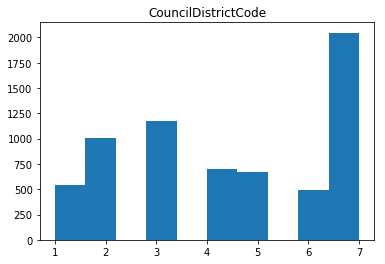

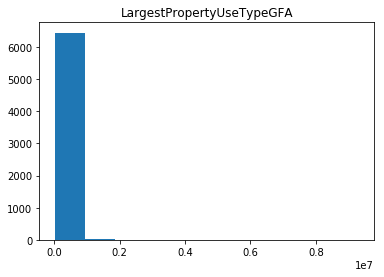

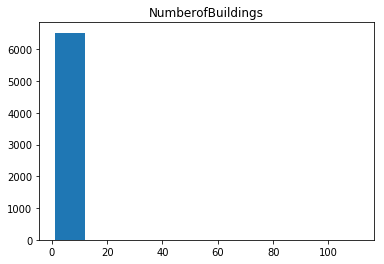

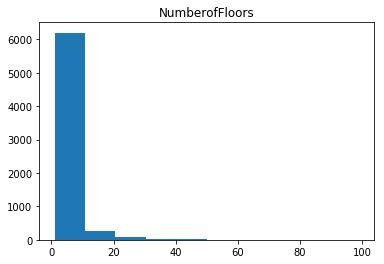

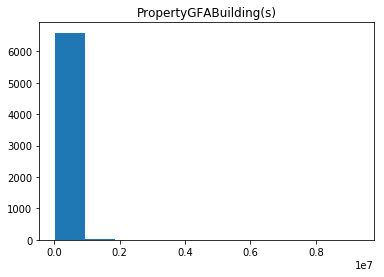

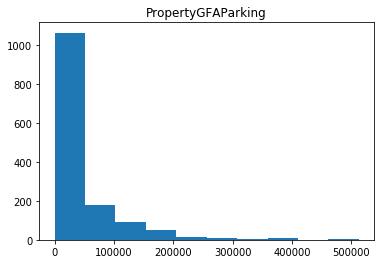

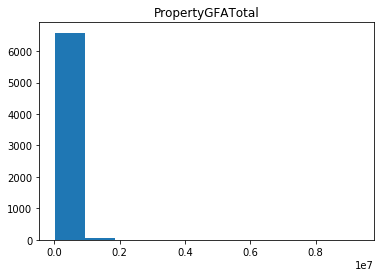

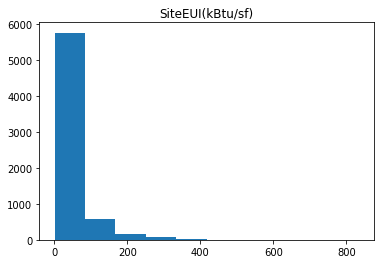

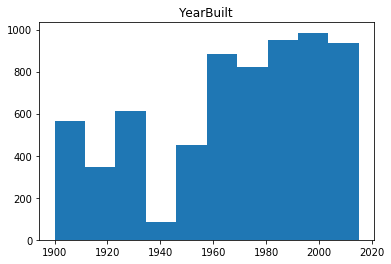

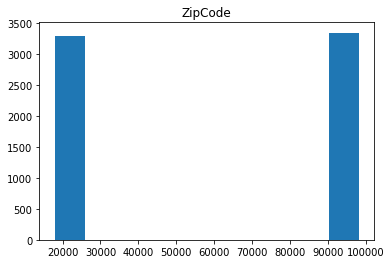

In [42]:
#Comment mettre les graphiques 4 par 4 ? 
for col in x.columns:
    #plt.figure()
    #spec2 = gridspec.GridSpec(ncols=5, nrows=5, figure=fig2)
    if col == 'Latitude' :
        continue 
    elif col == 'Longitude':
        continue
    else:
        plt.hist(x[col])
        plt.title(col)
        plt.show()

Pas de valeur abberante ici

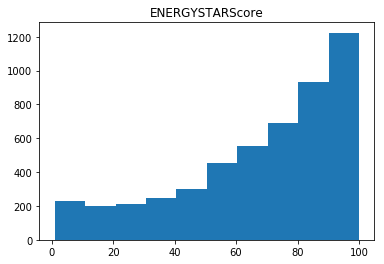

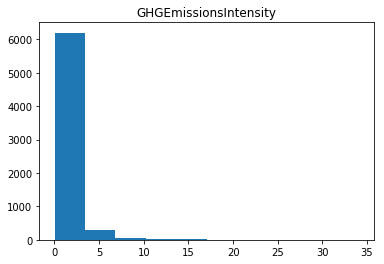

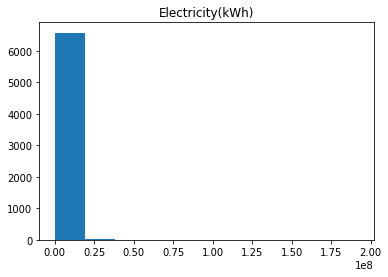

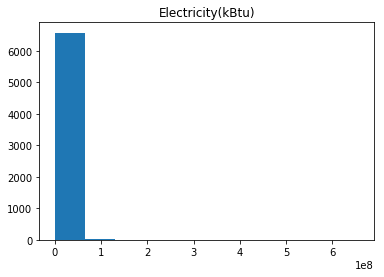

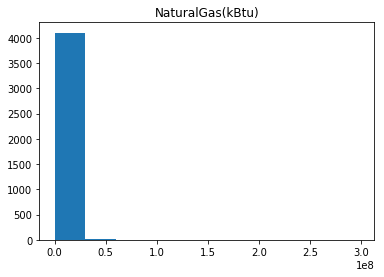

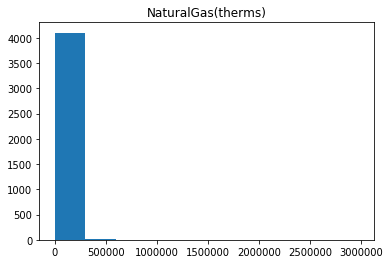

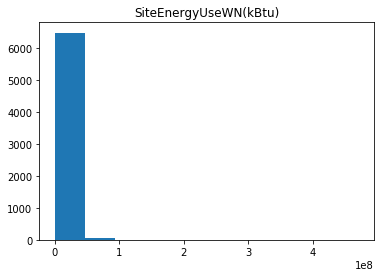

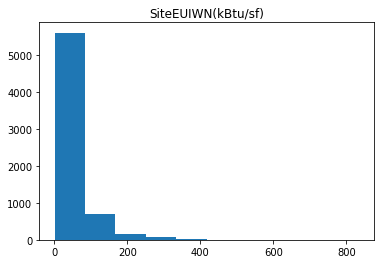

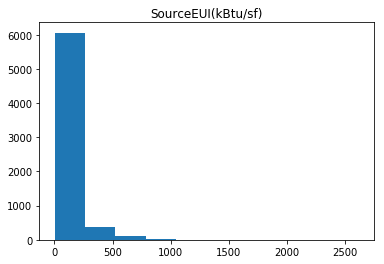

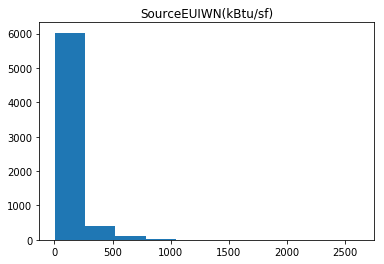

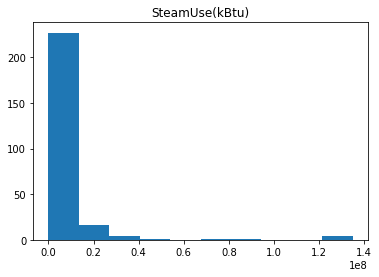

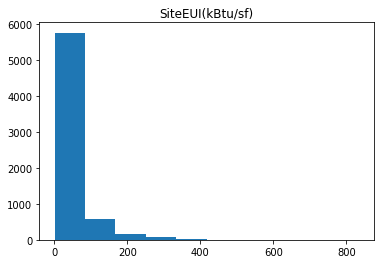

In [44]:
for col in energy.columns:
    #plt.figure()
    #spec2 = gridspec.GridSpec(ncols=5, nrows=5, figure=fig2)
    if col == 'Latitude' :
        continue 
    elif col == 'Longitude':
        continue
    else:
        plt.hist(energy[col])
        plt.title(col)
        plt.show()

SteamUse(KBTu) semble avoir une valeur abberante ; A voir en détail

Voyons nos deux variables cibles : 

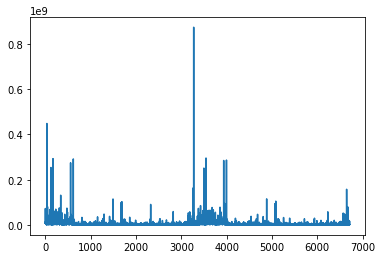

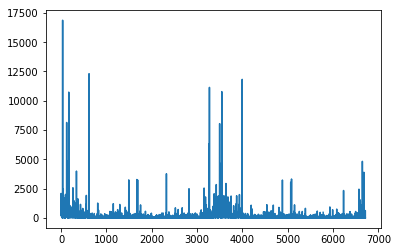

In [36]:
for cible in y.columns :
    y[cible].plot()
    plt.show()

A voir si relevant ou pas

## Bivariées

Attardons nous d'abord sur nos deux variables cibles : 

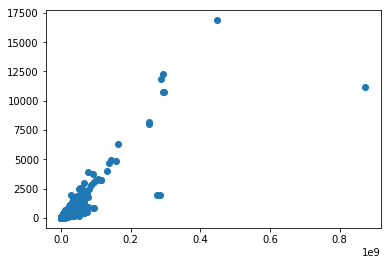

In [39]:
plt.scatter(y['SiteEnergyUse(kBtu)'], y['TotalGHGEmissions'])
plt.show()

Nos deux variables cibles semblent être corrélées entre elles (on pouvait s'y attendre)

C:\Users\jpaul\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jpaul\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


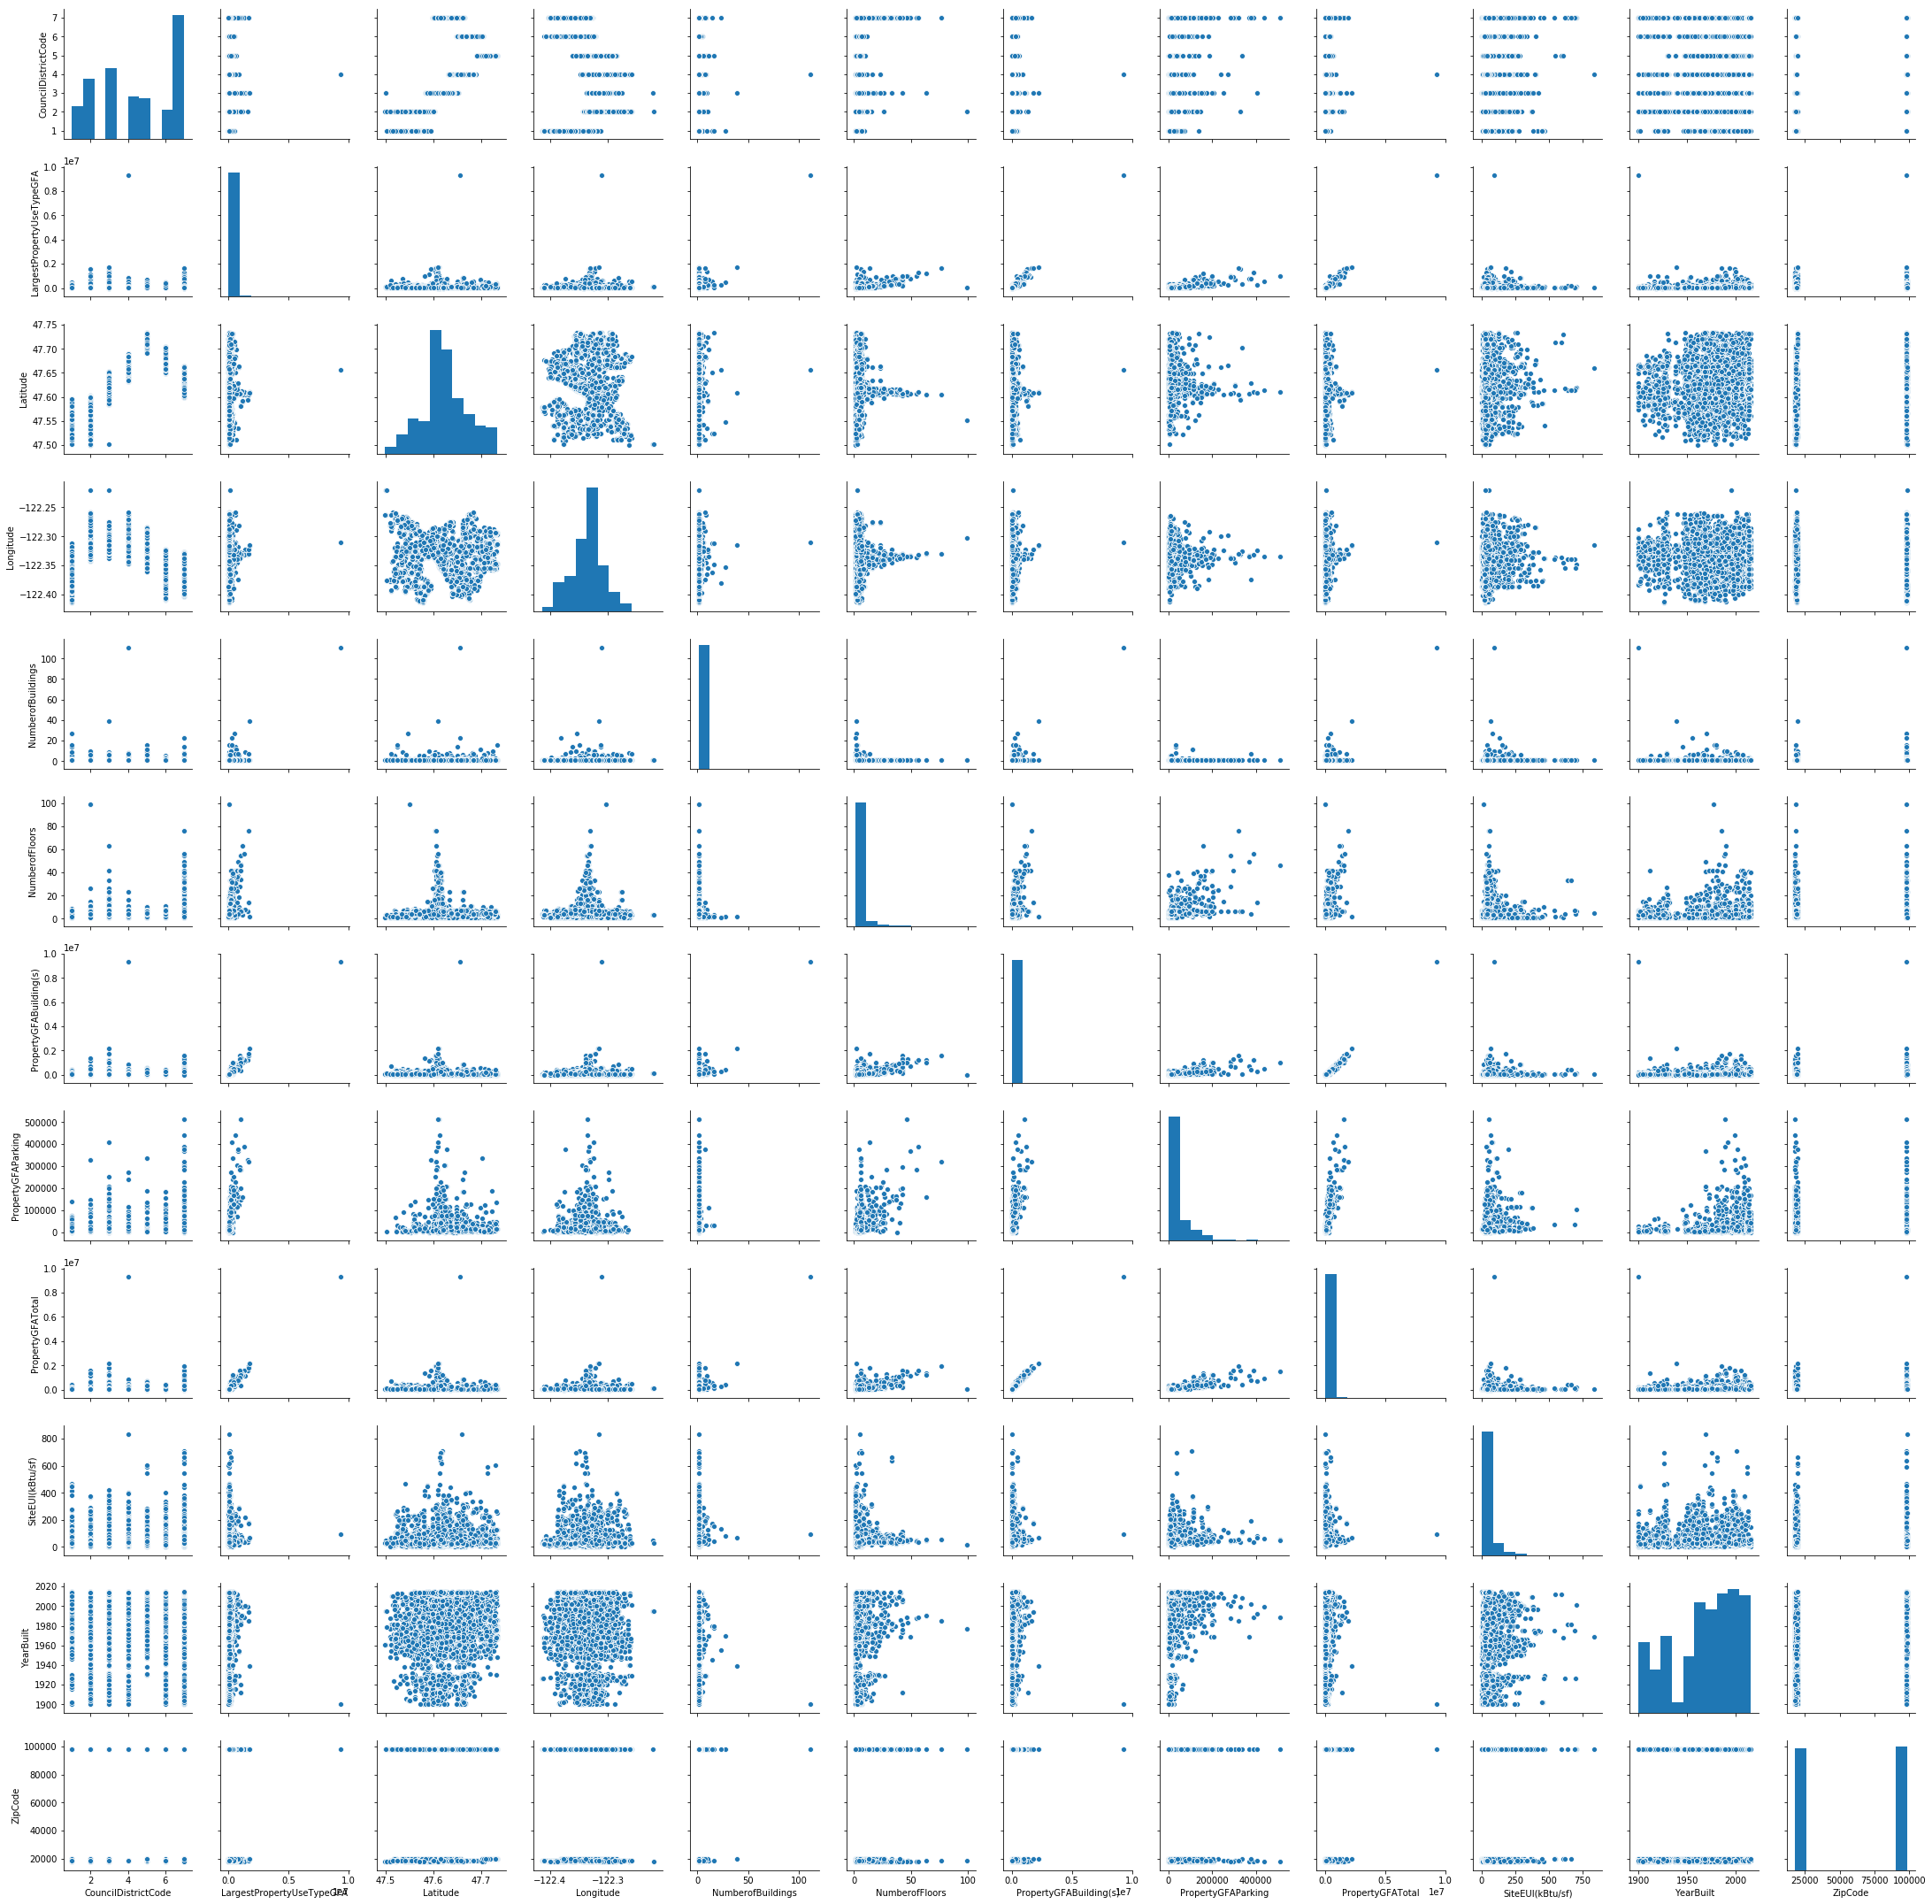

In [40]:
sns.pairplot(x)
#plt.savefig("Graphiques/analyses_bivariees.png")
plt.show()

### Matrice de corrélation

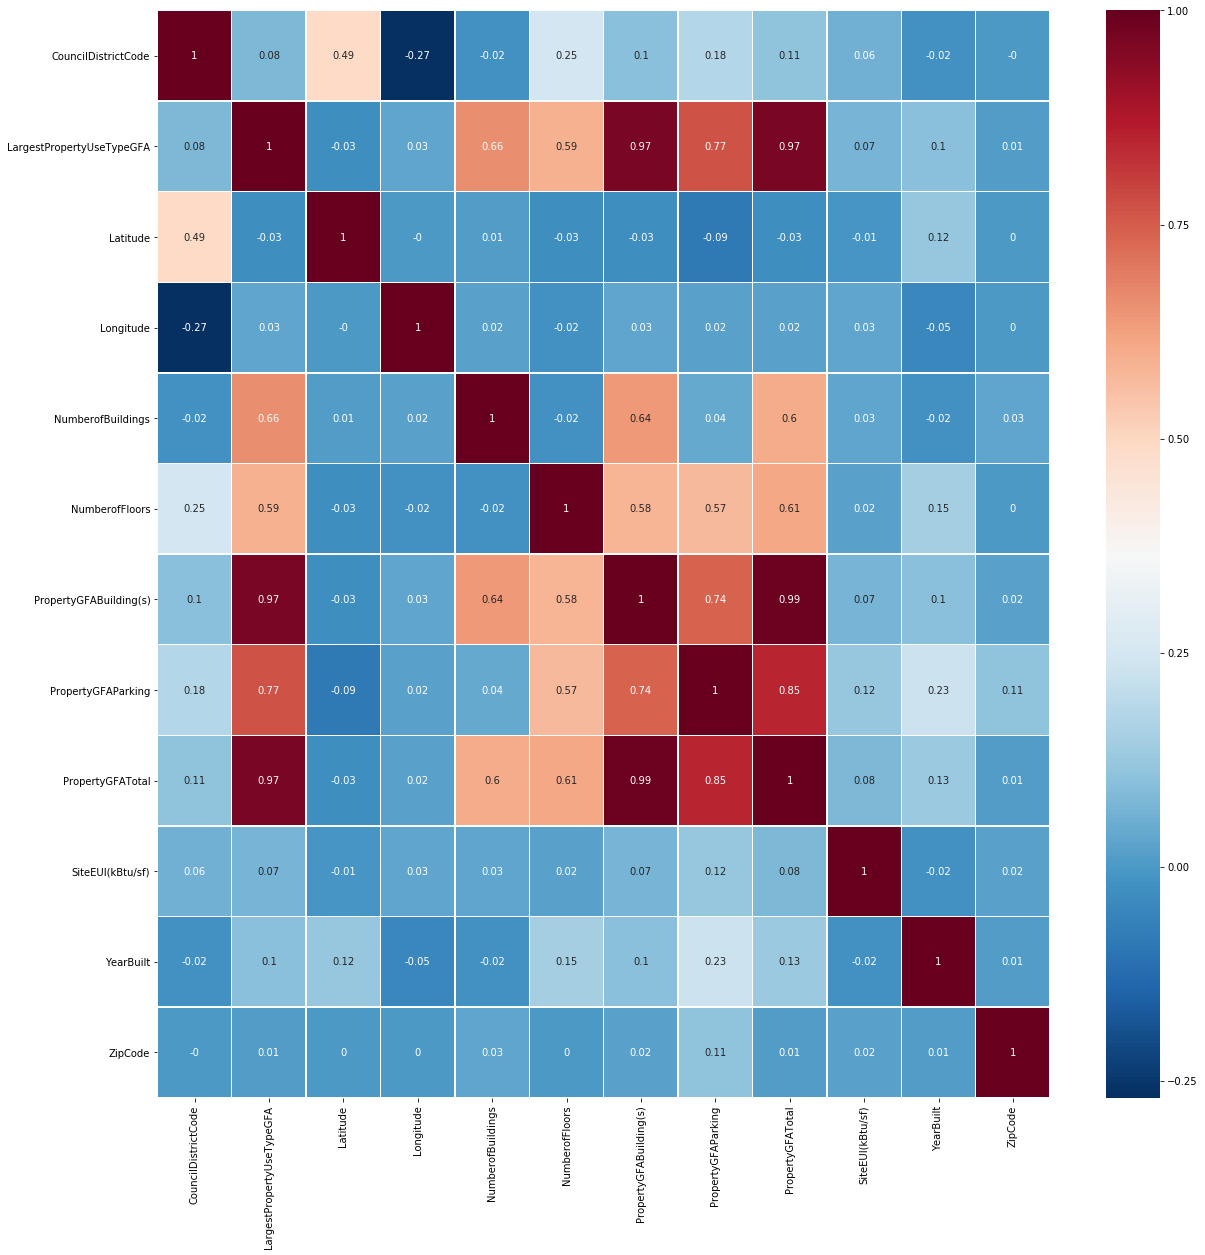

In [41]:
pearson_corr = round(x.corr(), 2)

plt.figure(figsize=(20,20))
sns.heatmap(pearson_corr, 
            xticklabels=pearson_corr.columns,
            yticklabels=pearson_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
plt.show()

On voit ici que beaucoup de variables sont corrélées entre elles